# MesoNet 

Access the MesoNet paper [here.](https://www.nature.com/articles/s41467-021-26255-2)

## Introduction:

MesoNet can be used through either a GUI or the command line interface (CLI). 
- This notebook will make use of the CLI for most commands. The GUI will only be used to label training data. 

<br>MesoNet can be used for two main alignment types:

ATLAS -> BRAIN: 
- Given a pre-trained DeepLabCut model that was trained to associate anatomical landmarks with corresponding points on atlases of brain regions, this approach registers an atlas of brain regions to the fixed brain imaging data using affine transformations. This approach is useful if your data has common anatomical landmarks and is the most robust to variations in image quality and orientation within your data.
- re-scales a reference atlas to fit brain data for regional anaysis of brain activity 

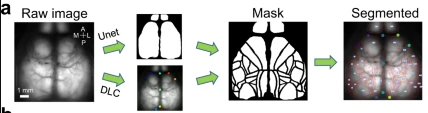

BRAIN -> ATLAS:
- Given a pre-trained DeepLabCut model that was trained to associate anatomical landmarks with corresponding points on atlases of brain regions, the brain imaging data is fixed onto an atlas of brain regions using affine transformations. This approach is useful if you would like to normalize your brain images to a common template based on anatomical landmarks.
- scales each brain to a common reference atlas with predicted landmarks 

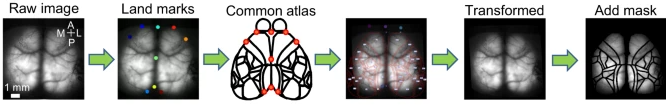

---

## The Configuration File

The configuration file is used to customize the MesoNet analysis. It is created in the `output_dir` location 
The full list of configuration parameters can be found [here](https://github.com/bf777/MesoNet/wiki/Config-File-Guide).


##### Model Training params of interest: 

- <ins>**epochs**</ins> default 60: The number of epochs for which the model will be trained. You may wish to reduce this number if you're updating an existing model.

- <ins>**log_folder**</ins> folder to which logging data should be output (and where this config file will be saved)

- <ins>**steps_per_epoch**</ins> default 300: The number of steps per training epoch. Influences the pace at which the model is trained.



##### Model Testing params of interest: 

- <ins>**model**</ins> location (within the MesoNet repository) of a U-Net model to be used for finding the boundaries of the brain region (as the default model does), or (if you have a specially trained model for this purpose) segmenting the entire brain into regions without the need for atlas alignment. Only choose another model if you have another model that you would like to use for segmenting the brain.

- <ins>**threshold**</ins> adjusts the sensitivity of the algorithm used to define individual brain regions from the brain atlas. Changing this number may significantly change the quality of the brain region predictions
    - increasing this number causes each brain region contour to be smaller (less like the brain atlas)
    - decreasing this number causes each brain region contour to be larger (more like the brain atlas).

- <ins>**olfactory_check**</ins> when True, draws olfactory bulb contours on brain image

- <ins>**align_once**</ins> if True, carries out all alignments based on the alignment of the first atlas and brain. This can save time if you have many frames of the same brain with a fixed camera position.

- <ins>**atlas_label_list**</ins> list of aligned atlases in which each brain region is filled with a unique numeric label. Allows for consistent identification of brain regions across images. If original_label is True, this is an empty list.

- <ins>**landmark_arr**</ins> The default number and order of landmarks to be used for the full alignment of a standard brain atlas to a brain image. Change what is contained in this list to change the landmarks used. When the default DeepLabCut model with nine landmarks, the landmarks are
    - 0: Anterolateral tip of the left parietal bone.
    - 1: Left frontal pole.
    - 2: Posterior tip of the left retrosplenial region.
    - 3: Cross point between the median line and the line which connects the left and right frontal pole.
    - 4: Bregma (centre point of cortex)
    - 5: Anterior tip of the interparietal bone.
    - 6: Anterolateral tip of the right parietal bone.
    - 7: Right frontal pole.
    - 8: Posterior tip of the right retrosplenial region.

---

## Set up the environment:

In [1]:
# make sure to activate your DEEPLABCUT environment before processing any data. 
!conda activate DEEPLABCUT

%matplotlib inline

# import all necessary modules

import mesonet
from data_loading_functions import *
import scipy.io
import numpy as np
from datetime import datetime
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import matplotlib as mpl 
from PIL import Image
from tqdm import tqdm
import glob
from IPython.display import clear_output
import re

# set verbose to True if you want to get feedback from each cell
verbose = True


Loading DLC 3.0.0rc3...


Initialize debugging functions

In [2]:
# helper functions 

# removes an output directory. 
def remove_output_dir(dir_path): 
    '''
    dir_path is either the path to the main Data_outputs folder (to remove all subfolders)
    or the path to a single subfolder. 
    '''

    shutil.rmtree(dir_path)

    if not os.path.exists("Data_outputs"): os.makedirs("Data_outputs")

    if verbose: print(f"Successfully deleted the {dir_path} folder and its contents.")

    return None

# move .npy files from the input_dir directory into a np_files directory
def move_np_files(source_dir, target_dir):
    np_file_num = len(glob.glob((os.path.join(source_dir, '*.npy'))))

    # if there are no npy files, return funtion
    if np_file_num != 0:
        # check if a np_files directory exists. If not, make one
        if not os.path.exists(target_dir): os.makedirs(target_dir) 
        
        # iterate through all .npy files and move them to the target_dir
        [shutil.move(file, os.path.join(target_dir, os.path.basename(file))) for file in glob.glob(os.path.join(source_dir, '*.npy'))]
        
        return np_file_num
    else:
        return 0
    
# removes all .png files from input_dir directory. Used for debugging and testing
def remove_png_files(source_dir):
    files_to_remove = glob.glob(os.path.join(source_dir, '*.png'))
    file_num = len(files_to_remove)

    # Iterate through all .png files and remove them with a progress bar
    for im in tqdm(files_to_remove, desc="Removing .png images", unit="image"):
        os.remove(im)
    
    if verbose:
        print(f"Finished removing all {file_num} .png files from {source_dir}")

    return None

# creates (if non-existant) and initializes an output directory in the Data_outputs directory
def define_output_path(output_dir):
    # check if user wants a specific directory name for all outputs
    if os.path.basename(output_dir) == "Data_outputs":
        # make a folder within the output_dir directory where we will keep track of all current outputs and config files for this run
        now = datetime.now()
        output_dir_w_time = os.path.join(output_dir, now.strftime("%Y-%m-%d_%H-%M"))
        os.makedirs(output_dir_w_time, exist_ok=True)

        output_dir = output_dir_w_time
        if verbose: print(f"New directory created: {output_dir} \nThis will be our output directory for the rest of the notebook.")
        
        return output_dir_w_time
    else:
        os.makedirs(output_dir, exist_ok=True)
        if verbose: print(f"Output Directory already exists and will be used for the rest of the notebook\npath: {output_dir}")
        
        return output_dir


Initialize visualization functions

In [4]:
# shows three grayscale images side by side. 
def visualize_trio(img_array):
    '''
    img_array: an array of length 3 with each index corresponding to an image path (str)
    '''
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Loop through each image and subplot axis
    for ax, im in zip(axs, img_array):
        # Read and display the image
        img = mpimg.imread(im)
        ax.set_facecolor('white')

        ax.imshow(img, cmap="gray")
        
        # Extract just the filename part and set it as the title
        filename = os.path.basename(im)
        ax.set_title(filename)
        
        # Remove the axes for a cleaner look
        ax.axis('off')


    # Display the figure
    
    plt.tight_layout()
    plt.show()

    return None

---

# ATLAS --> BRAIN

Two models are used for this process:
1. a trained **U-Net model** (.hdf5)
    - used to deliminate the brain from the rest of the image (cortex boundary delimiation)
2. a trained **DeepLabCut model**
    - used to label the 9 cortical landmarks on each brain image (landmark estimation)
    - originally trained with 491 images and their human-annotated labels 

<br>Default MesoNet models are from the OSF repository. 


<br>Click on the following sections based on your needs: 
- [I already have my two trained models and have access to their respective paths](#atlas---brain-model-testing)
    - * All models need to be in a folder called `models` within the *mesonet* directory of the MesoNet git repo.
- [I need to train one or both models (online training of an existing model or training of a new model)](#atlas---brain-model-training)


# ATLAS -> BRAIN: Model Testing

### <ins> Testing: Data Preparation:</ins> (.dat or .npy --> .png)

MesoNet requires that images be 8-bit (value 0-255) .png files in order to be used.

All input data for a single session / processing run must be in a single directory containing one of the following: 
1. a series of .png brain images (may also contain a .dat file but NO .npy files)
2. a single .dat file
    - the function below will create the proper image types from this file

<br>Add the path to this input directory into the `input_dir` variable below.  

If desried, specify the path of a directory in which to output all processing data in the `output_dir` variable. 
- If not specified, an output directory within `Data_outputs` will be created with the current date and time. 

In [5]:
# add the path to the input and output directories as specified above
input_dir = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_inputs"
output_dir = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_outputs\2024-08-19_11-06" # add the name of a specific folder if you want to name your own or if you want to use an existing one



We now need to make sure our input folder contains the proper type of 8bit .png images as mentioned above.

In [6]:
# our pipeline works with a stack of np arrays representing the wfield images.
# prepare the data as it would appear after coming out of the preprocessing pipeline.
# For this example, we will load only 500 of the original 10000+ brain images. 

# check if there are .png images already present in the Data_inputs folder.
if len(glob.glob(f"{input_dir}/*.png")) != 0: # there are images present
    im_num = len(glob.glob(os.path.join(input_dir, "*.png")))
    if verbose: print(f"There are already {im_num} images in the input dir. \nMake sure the images are 8-bit (0-255 value) before proceeding.")

else: # There must be a .dat file
    # make a numpy array from the .dat file
    np_img_stack = load_dat_frames(filename=glob.glob(os.path.join(input_dir, '*.dat'))[0])
    if verbose: print(f"numpy stack successfully loaded from .dat file. It has shape: {np_img_stack.shape}.")

    # make sure the array is of correct dimension: we only want access to the blue frames (single channel)
    if len(np_img_stack.shape) == 4:
        if np_img_stack.shape[1] != 1:
            np_img_stack = np_img_stack[:,0,...]
        else: np_img_stack = np.squeeze(np_img_stack, axis=1)
    
    # TODO: remove the lightweight option when making full version of this code. 
    np_img_stack = np_img_stack[:4000,...]

    # make sure all array is of type uint8 with values 0-255
    if np_img_stack.dtype == 'uint16':
        # normalize the values to be between 0-1
        normalized_stack = (np_img_stack - np.min(np_img_stack)) / (np.max(np_img_stack) - np.min(np_img_stack))
        # scale to range 0-255
        scaled_stack = normalized_stack * 255.0
        # convert to uint8
        np_img_stack = scaled_stack.astype(np.uint8)
        # TODO: remove this if necessary
        # Rotate images 180 degrees 
        np_img_stack = np_img_stack[:, ::-1, ::-1]

    
    # Convert the NumPy stack into a series of .png images with a progress bar
    for i, im in enumerate(tqdm(np_img_stack, desc="Saving images as .png", unit="image")):
        im_file_name = os.path.join(input_dir, f"{i}.png")
        Image.fromarray(im).save(im_file_name)
    
    if verbose: print(f"{i+1} .png files have been created in the {input_dir} directory.")


# make sure there are no .npy files in the Data_inputs directory as this will impact the MesoNet processing
np_file_num = move_np_files(input_dir, "np_files")
if verbose:
    if np_file_num > 0: print(f"{np_file_num} numpy files were moved from {input_dir} to the np_files directory.")

There are already 4000 images in the input dir. 
Make sure the images are 8-bit (0-255 value) before proceeding.


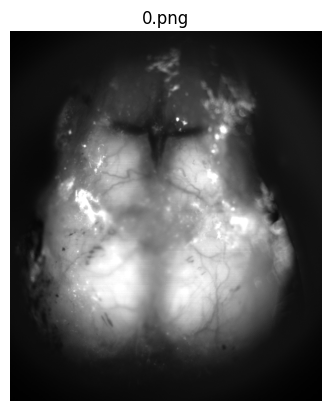

In [7]:
# visualize an image from the Data_inputs folder

img = mpimg.imread((glob.glob(f"{input_dir}/*.png"))[0])

plt.imshow(img, cmap='gray')
plt.axis('off') 
plt.title(os.path.basename(glob.glob(f"{input_dir}/*.png")[0]))
plt.show()

### <ins> Testing: running the model:</ins> 

We will be using the same `input_dir` and `output_dir` variables as previously loaded. Make sure these are correctly initialized before proceeding. 

<br>The model is tested according to a **config file** that contains important modifiable parameters. 
- Please see the [Config File Guide](#config-file-guide) for a full list of parameters that can be supplied in the .yaml configuration file.
- Specific code can be found [here](https://github.com/bf777/MesoNet/blob/master/mesonet/utils.py).


<br>Two functions are called to run the model. 
1. `mesonet.predict_regions(config_file)`
    - Segments brain regions using a U-Net model, based on parameters supplied in a .yaml configuration file.
2. `mesonet.predict_dlc(config_file)`
    - Predicts the locations of cortical landmarks on the brain, then uses these cortical landmarks (and, optionally, the U-Net model outputs) to register a standard brain atlas to the brain image.


`model_name`: (optional) Set a new name for the unet model to be trained. Default is 'unet.hdf5'.
    - if the model name already exists in the MesoNet git repo, the existing model will be trained with the data provided (online training) rather than training a new model 


`config`: Select the config file for the DeepLabCut model to be used for landmark estimation. 

`atlas`:  Set to True to just predict the cortical landmarks on your brain images, and not segment your brain images by region. Upon running mesonet.predict_dlc(config_file), MesoNet will output your brain images  labelled with these landmarks as well as a file with the coordinates of these landmarks. Set to False to carry out the full brain image segmentation workflow. 

`use_dlc`: Choose whether or not to try and register the atlas and brain image using a DeepLabCut model.

`atlas_to_brain_align`: If True, registers the atlas to each brain image. If False, registers each brain image to the atlas. 

`plot_landmarks`: If True, plots DeepLabCut landmarks (large circles) and original alignment landmarks (small  circles) on final brain image. 

`align_once`: if True, carries out all alignments based on the alignment of the first atlas and brain. This can save time if you have many frames of the same brain with a fixed camera position.

`model`: The location (within the MesoNet repository) of a U-Net model to be used for finding the boundaries  of the brain region (as the default model does), or (if you have a specially trained model for this purpose) segmenting the entire brain into regions without the need for atlas alignment. Only choose another model if you have  another model that you would like to use for segmenting the brain.

In [ ]:

# prepare the configuration file for our testing
config_file = mesonet.config_project(
    atlas = False,                      #  when False, carries out the full brain image segmentation workflow
    #config =  r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\training_Aug_7\DLC\MesoNet-Brune-2024-08-08\config.yaml",           # location within MesoNet repo of a DeepLabCut config file that references the landmark alignment model
    model = r"C:\Users\bbettl\PycharmProjects\MesoNet\mesonet\models\Trenholm_Unet.hdf5", # The location (within the MesoNet repository) of a U-Net model to be used for finding the boundaries of the brain region
    input_dir = input_dir, 
    output_dir = output_dir,
    mode = 'test', 
    mask_generate=False, # unsure what this is exactly 
    olfactory_check=True, 
    use_unet=True, 
    use_dlc=True, 
    atlas_to_brain_align=True, 
    use_voxelmorph=False,
    align_once = False)

if verbose: print(f"config_file has been created with input_file and output_file paths \nConfig file location: {output_dir}")

In [ ]:
mesonet.predict_regions(config_file)
clear_output(wait=True)

# now there are .png images in output_mask
imgs = [(glob.glob(f"{output_dir}/output_overlay/*mask_binary.png"))[0], (glob.glob(f"{output_dir}/output_overlay/*mask_segmented.png"))[0], (glob.glob(f"{output_dir}/output_overlay/*overlay.png"))[0]]

visualize_trio(imgs)

In [ ]:
%%capture
# 500 images takes ~ 5m to run (Aug 5th 2024)
# 500 of nicole's images takes ~ 7 minutes to run 
# 4000 matt images takes ~30 min to run  
mesonet.predict_dlc(config_file)

 big dots denote predicted landmarks on raw image, small dots denote landmarks on a common atlas

In [ ]:
img_list = glob.glob(f"{output_dir}/output_overlay/*_segmented.png")
show = img_list[0:3]
visualize_trio(show)

# ATLAS -> BRAIN: Using MesoNet Outputs

Within the outputs folder specified when running the MesoNet pipeline three folders appear:
1. dlc_output
2. output_mask
3. output_overlay

A series of .mat files can be found in `output_overlay/mat_contour`.

Each file contains the location of each ROI for each image. 

The ROI: 
- has format = a 512x512 array consisting of 0 or 255 values. 
- is defined by all pixel locations having value 255.   

WILL BE USEFUL TO GO ABOUT IT ALL IN BATCHES SINCE EITHER A DICTIONARY OR A LARGE ARRAY WILL BE COSTLY SPACE WISE !!
DICTIONARY ~25.6 GB AND NP ARRAY ~51.2GB 

In [8]:
# processing .mat file helper functions

def _get_fileName_info(file_name):
    '''
    file_name = str file name 
    returns tuple = (file_index, region_index) both as int
    '''
    pattern =  re.compile(r'roi__(\d+)_(\d+)_')

    indices = pattern.search(file_name)
    
    return (int(indices.group(1)), int(indices.group(2)))

def _get_mat_to_array(mat_contour_dir, regions=None):
    '''
    mat_contour_dir = directory path containing all .mat contour 512x512 files
    regions = array with the number value of the desired regions. np array dimensions will be in the order specified in the list. If None, all regions will be included. 
    returns an np array of dimension frame_numx40x512x512 (40 regions)
    '''

    mat_paths = glob.glob(f"{mat_contour_dir}/*.mat")
    file_names = []

    # determine the number of frames. this can be determined by the roi__X_ value in the file name

    frame_num = 0 
    for file_path in mat_paths:
        file_name = os.path.basename(file_path)
        file_names.append(file_name)
        curr_frame_num = _get_fileName_info(file_name)[0]
        if curr_frame_num > frame_num: 
            frame_num = curr_frame_num

    frame_num += 1  # add one because we end at the last frame index == len(frames)-1

    if verbose: print(f"{frame_num} frames present in {mat_contour_dir}.")

    # if regions in none, initialize a np array of size frame_numx41x512x512
    if regions == None:
        shape = (frame_num, 41, 512, 512)
        contour_array = np.full(shape, -1) 

        # fill the array given the data from the .mat files 
        for i, file_name in tqdm(enumerate(file_names), desc="Extracting contour data", unit="file"):
            # extract the frame num and the region number 
            frame_index, region_index = _get_fileName_info(file_name)
            # load the .mat array into a python np array 
            mat_data = scipy.io.loadmat(mat_paths[i])
            mat_data = np.array(mat_data[file_name[:-4]])
            # add array in correct contour_array location frame_index,region_index
            contour_array[frame_index][region_index] = mat_data

    else: # specific regions were specified 
        shape = (frame_num, len(regions), 512, 512)
        contour_array = np.full(shape, -1)

        # fill the array given the data from the .mat files 
        for i, file_name in tqdm(enumerate(file_names), desc="Extracting contour data", unit="file"):
            # extract the frame num and the region number 
            frame_index, region_index = _get_fileName_info(file_name)
            
            # check that the region_num is in our list
            if region_index in regions:
                # extract the index of that region in the input list
                j = regions.index(region_index)

                # load the .mat array into a python np array 
                mat_data = scipy.io.loadmat(mat_paths[i])
                mat_data = np.array(mat_data[file_name[:-4]])

                # append the converted .mat array in that location 
                contour_array[frame_index][j] = mat_data

    return contour_array


    '''
    returns a list of dictionaries (located at index=image number) with each dictionary having key = zone number and value = a 512x512 binary array 
    '''
    mat_files = glob.glob(f"{mat_contour_dir}/*.mat")
    image_rois = []

    # iterate through all files 
    for file in mat_files:
        # determine the image number and ROI number from the file name 
        # convert the .mat into a np array 
        # convert all values into 0 or 1 rather than 0 or 255 / determine what values are in here 
        # add to dict as needed 

        roi_dict = {}

    return image_rois

def avg_mask_calc(input_pixel_array, mask_array):
    '''
    returns a single value indicating the average pixel value of the input image at the given mask location. Returns -1 if the mask does not exist / has value -1. 
    '''
    if not np.any(mask_array == -1): # if mask contains a -1. ie it does not exist for this frame

        # Convert the mask to a boolean mask (0s become False, 255s become True)
        mask_bool = (mask_array == 255)

        # Apply the mask and calculate the average of the pixels in the mask area
        valid_pixels = input_pixel_array[mask_bool]
        average_pixel_value = valid_pixels.mean()
        return average_pixel_value
    
    else:
        return -1

def seg_lum_diff_over_time(input_dir, mat_contour_dir, regions=None):
    '''
    input_dir = path to input images
    mat_contour_dir = path to .mat segmented contours corresponding to all images in input_dir OR a single array of shape 41x512x512 to use for ALL images 

    returns: None / plots the luminance values over time per region (as a different line) 
    '''
    if isinstance(mat_contour_dir, str):
        # get the array of masks corresponding to all input frames and the regions of interest 
        contours_array = _get_mat_to_array(mat_contour_dir, regions)
        
   
    frame_paths = glob.glob(os.path.join(input_dir, "*.png"))
    frame_num = len(frame_paths)

    if regions != None: # regions were specified 
        # initialize array in which we will store the values to graph 
        region_values = np.full((len(regions), frame_num), -1)
        
        for frame_path in frame_paths:
            # determine the frame name=index
            file_name = os.path.basename(frame_path)
            frame_index = int(file_name[:-4])

            # extract the image array from the .png file and resize to mask size 
            frame = np.array(Image.open(frame_path).resize((512, 512)))
         
            for reg in regions:
                reg_index = regions.index(reg)
                
                # get correct mask
                if isinstance(mat_contour_dir, str):
                    mask_to_use = contours_array[frame_index][reg_index]
                elif isinstance(mat_contour_dir, np.ndarray):
                    mask_to_use = mat_contour_dir[reg_index]

                # calculate the average pixel value at the given mask location IFF the mask != -1
                avg_pixel_value = avg_mask_calc(frame, mask_to_use)
                region_values[reg_index][frame_index] = avg_pixel_value

    else: # go through all regions 
        regions = list(range(41))

        region_values = np.full((41, frame_num), -1) 
        
        for frame_path in frame_paths:
            # determine the frame name=index
            file_name = os.path.basename(frame_path)
            frame_index = int(file_name[:-4])

            # extract the image array from the .png file and resize to mask size 
            frame = np.array(Image.open(frame_path).resize((512, 512)))
        
            for i in regions:
                # get correct mask
                # get correct mask
                if isinstance(mat_contour_dir, str):
                    mask_to_use = contours_array[frame_index][i]
                elif isinstance(mat_contour_dir, np.ndarray):
                    mask_to_use = mat_contour_dir[i]

                # calculate the average pixel value at the given mask location IFF the mask != -1
                avg_pixel_value = avg_mask_calc(frame, mask_to_use)
                region_values[i][frame_index] = avg_pixel_value
        
    # we now have the average values per region over time (over frames)
    plt.figure(figsize=(10, 6))

    time_points = np.arange(frame_num) + 1

    for i in regions:  # iterate over regions
        region_index = regions.index(i)

        region_data = region_values[region_index, :]

        # only plot regions that are visible throughout the recording 
        if not np.any(region_data == -1): 
            plt.plot(time_points, region_data, label=f'Region {i}')

            '''# TEMP
            peaks, _ = scipy.signal.find_peaks(region_data, distance=75)
            print(len(peaks))
            break'''

    # Label the axes
    plt.xlabel('Frame')
    plt.ylabel('Average Pixel Value')

    plt.title('ROI Pixel Values Over Time')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()   

    return            

Visualize a contour mask below.

In [ ]:
mat_contour_dir = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_outputs\2024-08-19_11-06\output_overlay\mat_contour"

test_array = _get_mat_to_array(mat_contour_dir)

test= test_array[0][1]
print(test.shape)

plt.imshow(test)
plt.colorbar()
plt.show()


In [ ]:
mat_contour_dir = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_outputs\2024-08-19_11-06\output_overlay\mat_contour"

contour = test_array[0]

seg_lum_diff_over_time(input_dir, mat_contour_dir=contour)

---
---

# ATLAS -> BRAIN: Model Training

### <ins> Training: Data Preparation: Initialization</ins> 

In order to train a new or existing U-net and DLC model, we need to collect a series of wfield images and prepare them for training. 
This involves annotating each image using the MesoNet and DLC GUI. 

As of August 14th 2024, we will be adding a batch of 26 images. 
- Each image comes from a different recording session from both Nicole and Matthew's expriment. 

In [ ]:
# create a function to convert a series of .dat files into a training dataset consisting of >= 20 .png w-field images. 
# THE .PNG FILES MUST BE OF THE FORMAT i.png WITH i RANGING FROM 0 TO train_set_length. 

def create_our_train_set(save_path, data_path_list, train_set_length=len(data_path_list)):
    '''
    function takes as input 
        - output_path: path of directory location, in which to store new training set. If file location does not exist, it will be created. Otherwise, it will be overwritten
        - data_path_list: a list of any number of .dat file paths from which to create training dataset
        - train_set_length: number >=20 (ideally) representing the number of training images to create
    ''' 

    # check if save_path exists. If not, create the directory
    os.makedirs(save_path, exist_ok=True)

    # determine the number of images to take from each .dat file
    dat_file_num = len(data_path_list)

    per_file_num = int(np.ceil(train_set_length / dat_file_num))

    # convert each .dat into a numpy array 
    
    #for i, im in enumerate(tqdm(np_img_stack, desc="Saving images as .png", unit="image"))
    im_counter = 0 
    for current_path in tqdm(data_path_list, desc="Creating and saving .png training images", unit="data file"):
        curr_data_array = load_dat_frames(current_path)

        if len(curr_data_array.shape) != 3: 
            if curr_data_array.shape[1] == 2: # np array still has two channels
                # take only the blue channel
                curr_data_array = curr_data_array[:,0,...]
            else:
                curr_data_array = np.squeeze(curr_data_array, axis=1)
        
        # rotate the images 180 degrees
        curr_data_array = curr_data_array[:, ::-1, ::-1]

        indices = np.linspace(0, len(curr_data_array[0]) - 1, per_file_num).astype(int)
        
        # extract the desired number of images from each array
        for i in indices:
            im_file_name = os.path.join(save_path, f"{im_counter}.png")
            
            curr_im_array = curr_data_array[i]

            # make sure array is of type uint8 with values 0-255
            if curr_im_array.dtype == 'uint16':
                # normalize the values to be between 0-1
                normalized_stack = (curr_im_array - np.min(curr_im_array)) / (np.max(curr_im_array) - np.min(curr_im_array))
                # scale to range 0-255
                scaled_stack = normalized_stack * 255.0
                # convert to uint8
                curr_im_array = scaled_stack.astype(np.uint8)
            
            # save these images into the output_path
            Image.fromarray(curr_im_array).save(im_file_name)
            im_counter += 1
                    
    if verbose: print(f"Done creating {train_set_length} training images from the {dat_file_num} files.")


Only run the following code if you need to extract images from .dat files. Ie. you do NOT yet have a folder containing (unannotated) images.  

In [ ]:
save_path = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\training_images_Aug_14"
path_to_dat_dir = r"D:\wfd training dat files"
data_path_list = glob.glob(f"{path_to_dat_dir}\*.dat")

print(f"There are {len(data_path_list)} different .dat files in the specified directory.")

create_our_train_set(save_path, data_path_list, len(data_path_list))


### <ins> Training: Data Preparation: Manual Masks and Annotations</ins> 

Now that the training set has been initialized as a series of unique .png images, we need to manually draw the corresponding U-Net masks and place the corresponding DLC point annotations. 

We will do this with the help of the MesoNet GUI. 

<ins>ACCESSING MESONET GUI:
1. open a `command prompt` terminal 
2. type the following code in subsequent lines of the cmd terminal

> conda activate DEEPLABCUT

You should now see `(DEEPLABCUT)` on the left of every line in the cmd terminal.

> ipython

> import mesonet

> mesonet.gui_start('train')


<ins> MesoNet Training GUI

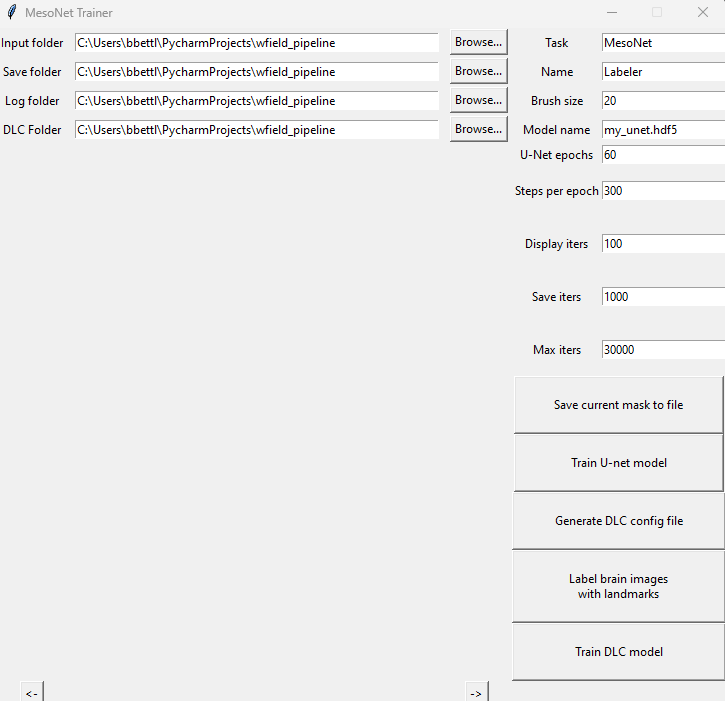

### Making U-Net Training Masks: 

On the left side of the MesoNet Training GUI 
1. Select the proper input folder path (path to the training dataset we just created)
2. Select the proper save folder path (path to a dir where our brain images and masks for training the model will be saved)
3. Select the proper log folder path (path to a dir where we want to record the output data from the U-Net model)
4. Select the proper DLC folder path (path to a dir where we want to save the DeepLabCut project)

Ignore the right side of the MesoNet Trainer GUI for now. 

We will now focus on the images that have now appeared on the GUI screen. 

5. Paint in the cortical region on the brain image
    - You can adjust the brush size for the painting (in pixels) by changing the value next to "Brush Size" in the top right part of the window. 
    - Click and drag on the image where you want to paint the cortical region (white pixels)
    - Once you're finished, click "Save current mask to file". This will save your painted region against a black background into a `label` subfolder of the directory you chose in "Save folder". 
    - A copy of the original image will also be saved into a corresponding `image` subfolder. 
    - Go through each image using the left and right arrow keys or the arrow buttons at the bottom of the screen, painting in the cortical region and clicking "Save current mask to file" each time. 
    
    ** *If you want to repaint an image, you can return to that image and paint it over again; saving it again will overwrite the original image.**

**The Image masks have now been created and are located in the save folder specified in the GUI and in step 2.**
**You will not have to draw the masks again (you may now close the GUI window). These steps do NOT need to be repeated now that it has been completed once with these training images.**

### Making landmark labels for DLC: 

<ins> Within the MesoNet Train GUI
* can be the same window as above or a new one

9. Name: Add your name as the labeler's name
10. Click "generate DLC config file" to generate new folder (within the DLC folder path) where DLC computations take place
    - folder will be of the following format: `Task-Labeler-YYYY-MM-DD`
11. Click Label brain images with landmakrs"
    - you will be taken to DEEPLABCUT's interface. 
    - you may have to type yes in the command line 

![mesonet.jpg](mesonet.jpg)

---
### <ins> Training: Model training</ins> 

We now have the images and their corresponding labels (masks and or landmark annotations).
We can now train an existing (online training) or new (data augmentation) model. 

We will be using the same `input_dir` and `output_dir` variables as previously loaded. Make sure these are correctly inticialized before proceeding. 


### U-Net Training (~2h)
1. Make sure the brain images are in a folder called `image`, and put the masks in a folder called `label`. Put both of these folders together in a single folder, which you'll use as your input folder.
2. Initialize the blue variables below 
    - `input_folder`: A directory containing an 'image' folder with brain images, and a 'label' folder with corresponding masks to segment these brain images.
    - `model_name`: The name of the new U-net model to be created
        - NOTE: If the model name that you select already exists in your copy of the MesoNet git repository, it will train the existing model with the data that you have provided (i.e. online learning) instead of training a new model. You may wish to do this if, for example, you have a good model and you want to train it on additional data to make it more robust
    - `log_folder`: The folder to which the performance of the model should be logged
    - `git_repo_base`: The path to the base git repository containing necessary resources for MesoNet (reference atlases, DeepLabCut config files, etc.)
    - `steps_per_epoch`: During U-Net training, the number of steps that the model will take per epoch. Defaults to 300 steps per epoch
    - `epochs`: During U-Net training, the number of epochs for which the model will run. Defaults to 60 epochs (set lower for online learning, e.g. if augmenting existing model).

The model itself, by default, is saved to the models folder of the MesoNet git repository.

In [9]:
# train U-net model
from mesonet.train_model import trainModel
from mesonet.utils import config_project

input_folder = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\trenholm_training_data\u-net"       
model_name =  "Trenholm_Unet_Aug-21.hdf5"      
log_folder =  r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\training_outputs_Aug_14\log" 
git_repo_base = r"C:\Users\bbettl\PycharmProjects\MesoNet\mesonet" 
steps_per_epoch = 300 
epochs = 60 

# creates and trains a U-net model with the specified model_name. 
trainModel(input_folder, model_name, log_folder, git_repo_base, steps_per_epoch, epochs)

# the model will be saved in the Mesonet/mesonet/models folder in the MesoNet Git directory.

Found 87 images belonging to 1 classes.
Found 87 images belonging to 1 classes.


c:\Users\bbettl\AppData\Local\anaconda3\envs\DEEPLABCUT\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\bbettl\AppData\Local\anaconda3\envs\DEEPLABCUT\lib\site-packages\mesonet\train_model.py:66: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_callback = model.fit_generator(


Epoch 1/60
300/300 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.8423
Epoch 1: loss improved from inf to 0.43270, saving model to Trenholm_Unet_Aug-21.hdf5
300/300 [==============================] - 175s 463ms/step - loss: 0.4327 - accuracy: 0.8423
Epoch 2/60
300/300 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.9092
Epoch 2: loss improved from 0.43270 to 0.39446, saving model to Trenholm_Unet_Aug-21.hdf5
300/300 [==============================] - 121s 403ms/step - loss: 0.3945 - accuracy: 0.9092
Epoch 3/60
300/300 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.9207
Epoch 3: loss improved from 0.39446 to 0.37917, saving model to Trenholm_Unet_Aug-21.hdf5
300/300 [==============================] - 121s 403ms/step - loss: 0.3792 - accuracy: 0.9207
Epoch 4/60
300/300 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.9259
Epoch 4: loss improved from 0.37917 to 0.36956, saving model to Trenhol

## U-Net model accuracy:



In [ ]:
from tensorflow.keras.models import load_model 
import skimage.transform as trans

# model .hdf5 should be in the Mesonet/mesonet/models folder. 
model_path = r"C:\Users\bbettl\PycharmProjects\MesoNet\mesonet\models\Trenholm_Unet.hdf5"
# path to test folder. contains a dir called 'images' and 'masks' used to test our U-net model 

input_dir = "Unet_test_data"

# ------ only modify above variables ---------

# load pre-trained U-net model with Keras
model = load_model(model_path)

# prepare the image data. Needs to be shape (batch_size, 512, 512, 1) 
# in the mesoNet code, they also divide 8bit images by 255.
# iterate through each image 
batch = []
for im in tqdm(glob.glob(f"{input_dir}/images/*.png"), desc="Preprocessing images", unit="image"):
    image = np.array(Image.open(im))
    image = image / 255
    resized = trans.resize(image, (512,512))
    final_im = np.expand_dims(resized, axis=-1)
    batch.append(final_im)

batch = np.stack(batch, axis=0)

# run image stack through model
predicted_mask = model.predict(batch)

if verbose: print(f"All images from {input_dir} have been run through the pretrained U-Net model.")

# visualize first 3 images and their proposed masks
fig, axs = plt.subplots(2, 3, figsize=(10, 5), constrained_layout=True)

# plot the original image on the top row 
axs[0,0].imshow(Image.open(glob.glob(f"{input_dir}/images/*.png")[0]), cmap="gray")
axs[0,1].imshow(Image.open(glob.glob(f"{input_dir}/images/*.png")[1]), cmap="gray")
axs[0,2].imshow(Image.open(glob.glob(f"{input_dir}/images/*.png")[2]), cmap="gray")

# plot the masks on the bottom row 
axs[1,0].imshow(predicted_mask[0], cmap="gray")
axs[1,1].imshow(predicted_mask[1], cmap="gray")
axs[1,2].imshow(predicted_mask[2], cmap="gray")

for ax in axs.flat:
    ax.axis('off')

## TODO HERE:

FIND A WAY HERE TO TEST EACH MODEL INDIVIDUALLY AND SHOW THE ACCURACY AS THEY DID IN THE PAPER ;) 

---


### DLC Training (~__h)


# BRAIN -> ATLAS

Follow same procedure to load data above into a directory whose path must be saved in a varaible called `input_dir` and an output directory path must be specified in the variable `output_dir`. 

In [ ]:
# specify the input and output directory paths

input_dir = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\5 images aug 19"
output_dir = r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\Data_outputs"

output_dir = define_output_path(output_dir)

In [ ]:
# create a config file set to brain -> atlas 
# prepare the configuration file for our testing
config_file = mesonet.config_project(
    atlas = False,                      #  when False, carries out the full brain image segmentation workflow
    #config =  r"C:\Users\bbettl\PycharmProjects\wfield_pipeline\training_Aug_7\DLC\MesoNet-Brune-2024-08-08\config.yaml",           # location within MesoNet repo of a DeepLabCut config file that references the landmark alignment model
    model = r"C:\Users\bbettl\PycharmProjects\MesoNet\mesonet\models\Trenholm_Unet.hdf5", # The location (within the MesoNet repository) of a U-Net model to be used for finding the boundaries of the brain region
    input_dir = input_dir, 
    output_dir = output_dir,
    mode = 'test', 
    mask_generate=False, # unsure what this is exactly 
    olfactory_check=True, 
    use_unet=True, 
    use_dlc=True, 
    atlas_to_brain_align=False, 
    use_voxelmorph=False,
    align_once = False)

if verbose: print(f"config_file has been created with input_file and output_file paths \nConfig file location: {output_dir}")

In [ ]:
%%capture
mesonet.predict_regions(config_file)

mesonet.predict_dlc(config_file)
